# Handwritten Javanese Script Classification
> A Convolutional Neural Network trained to predict handwritten Javanese Script.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, code, python, deeplearning]
- image: images/javanese-ha.jpg

## Background
### Aksara Jawa
*Aksara Jawa*, or the [Javanese Script](https://en.wikipedia.org/wiki/Javanese_script) is the core of writing of the Javanese language and has influenced various other regional languages such as Sundanese, Madurese, etc. The script is now rarely used on a daily basis, but is sometimes taught in local schools in certain provinces of Indonesia.

### Specific Form of Aksara
The Javanese Script which we will be classifiying is specifically [Aksara Wyanjana](https://en.wikipedia.org/wiki/Javanese_script#Wyanjana)'s *Nglegena*, or its basic characters. The list consists of 20 basic characters, without their respective *Pasangan* characters.

### Dataset
Since I have not been able to find a handwritten Javanese Script dataset on the internet, I have decided to contact one of my English highschool teachers who has once showed my class her ability to write Javanese Script. The characters were written on paper, scanned, and edited manually. Credits to **Mm. Martha Indrati** for the help!

### Image Classification
This project is very much inspired from datasets like [MNIST](http://yann.lecun.com/exdb/mnist/) and [QMNIST](https://github.com/facebookresearch/qmnist) which are handwritten digits and is a go-to dataset for starting to learn image classification. The end goal of this project is to be able to create a deep learning model which will be able to classify handwritten Javanese Script to a certain degree of accuracy.

## Code
The main framework to be used is fastai-v2, which sits on top of PyTorch. Fastai-v2 is still under development as of the time of this writing, but is ready to be used for basic image classification tasks.

In [1]:
from fastai2.vision.all import *
import torch

### Load Data
The data has been grouped per class folder, which we'll load up and later split into training (70%) and validation (30%) images.

In [2]:
path = Path("handwritten-javanese-script-dataset")

Notice we're using a small batch size of 5, mainly because we only have 200 images in total.

Here we'll apply cropping and resizing as transformations to our image since most of the characters do not fully occupy the image size. Additionally, we'll resize to 128px.

In [3]:
dblock = DataBlock(blocks     = (ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_items  = get_image_files,
                   splitter   = GrandparentSplitter(valid_name='val'),
                   get_y      = parent_label,
                   item_tfms  = [CropPad(90), Resize(128, method=ResizeMethod.Crop)])

In [4]:
dls = dblock.dataloaders(path, bs=5, num_workers=0)

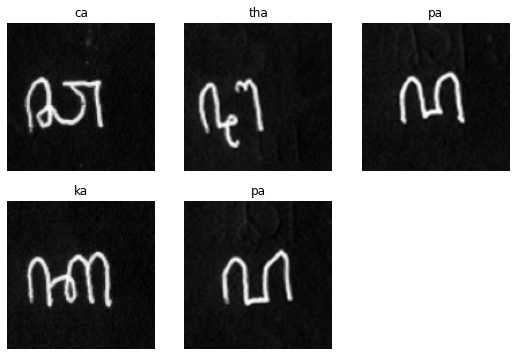

In [5]:
dls.show_batch()

There are only 20 types of characters in the type of Aksara which we'll be classifying.

In [6]:
dls.vocab

(#20) ['ba','ca','da','dha','ga','ha','ja','ka','la','ma'...]

### Model
We'll be using **XResNet50** as the model, which is based on the [Bag of Tricks paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/He_Bag_of_Tricks_for_Image_Classification_with_Convolutional_Neural_Networks_CVPR_2019_paper.pdf) and is an "extension" to the [ResNet50](https://arxiv.org/abs/1512.03385) architecture. We'll pass our data, tell which metrics we'd like to observe, utilize `LabelSmoothingCrossEntropy`, and add `MixUp` as our callback.

In [112]:
learn = Learner(dls, xresnet50(c_in=1, n_out=dls.c), metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(), cbs=MixUp)

### Training Model
With all things in place, let's finally train the model to learn from the given dataset and predict which class the image belongs to.

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=6.309573450380412e-07)

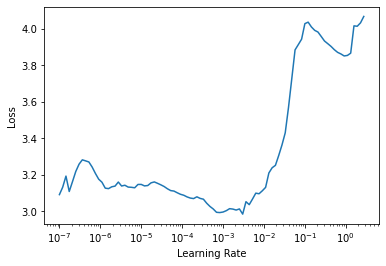

In [113]:
learn.lr_find()

In [114]:
learn.fit_one_cycle(30, 3e-4, cbs=SaveModelCallback(monitor='accuracy', fname='best_model'), wd=0.4)

epoch,train_loss,valid_loss,accuracy,time
0,3.067268,3.108827,0.050000,00:04
1,2.929908,2.669373,0.333333,00:04
2,2.769148,2.293764,0.383333,00:04
3,2.588481,2.215439,0.316667,00:04
4,2.416248,2.324036,0.283333,00:04
5,2.324458,1.983255,0.533333,00:04
6,2.189000,2.105889,0.383333,00:04
7,2.078479,2.350886,0.333333,00:04
8,1.922369,2.823610,0.216667,00:05
9,1.790820,1.584189,0.650000,00:05


Better model found at epoch 0 with accuracy value: 0.05000000074505806.
Better model found at epoch 1 with accuracy value: 0.3333333432674408.
Better model found at epoch 2 with accuracy value: 0.38333332538604736.
Better model found at epoch 5 with accuracy value: 0.5333333611488342.
Better model found at epoch 9 with accuracy value: 0.6499999761581421.
Better model found at epoch 12 with accuracy value: 0.8333333134651184.
Better model found at epoch 19 with accuracy value: 0.8999999761581421.
Better model found at epoch 21 with accuracy value: 0.9333333373069763.
Better model found at epoch 22 with accuracy value: 0.949999988079071.


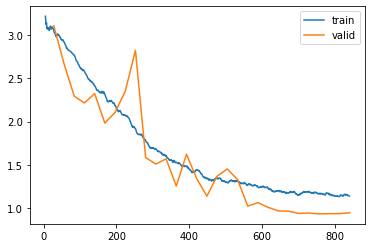

In [115]:
learn.recorder.plot_loss()

In [116]:
learn.save('stage-1')

### Analyze Results
After training, let's see how well our model learned. Any incorrect prediction in a random batch will have its label colored red.

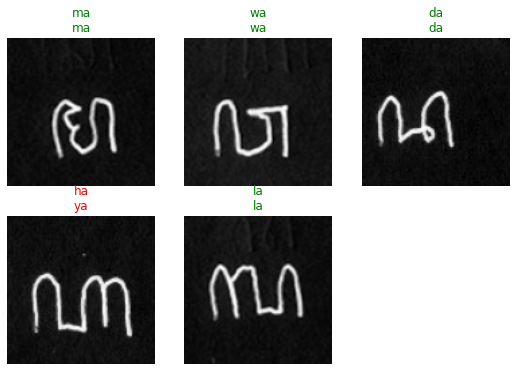

In [117]:
learn.show_results()

Instead of only viewing a batch, let's analyze the results from the entire validation dataset.

In [118]:
interp =  ClassificationInterpretation.from_learner(learn)

This confusion matrix lists all the actual versus predicted labels. The darker the blue on the diagonal line, the better our model is at predicting.

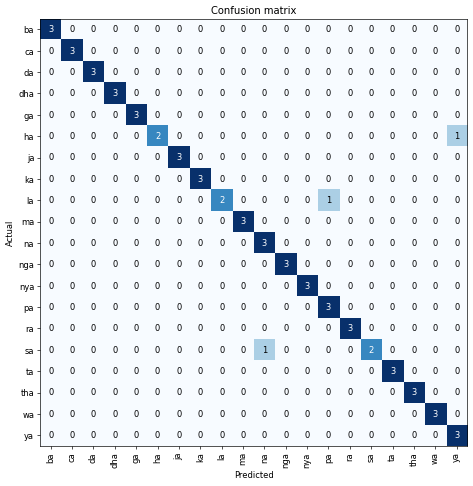

In [119]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

On the other hand, this type of interpretation shows several of the predicted images, what our model thinks it is, and how confident it is with that prediction.

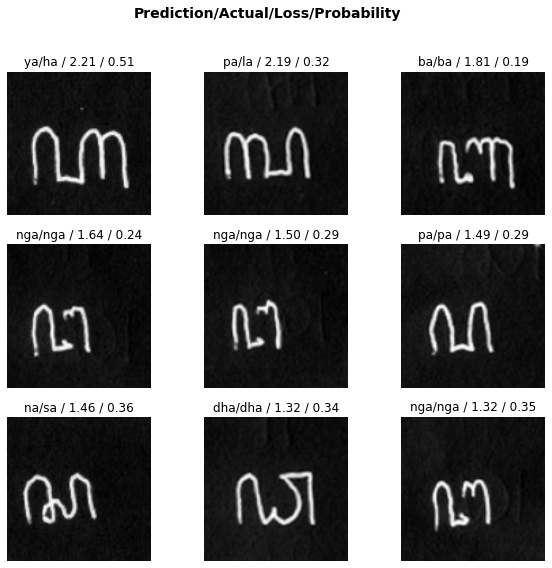

In [120]:
interp.plot_top_losses(9, figsize=(10,9))

### Predicting External Images
To see how our model's regularization fairs, let's attempt to feed it an external data and see what it predicted.

In [121]:
from PIL import Image

In [142]:
def open_image_bw_resize(source) -> PILImageBW:
    return PILImageBW(Image.open(source).resize((128,128)).convert('L'))

The following character is supposed to be **ma** and was picked randomly from available images on the internet.

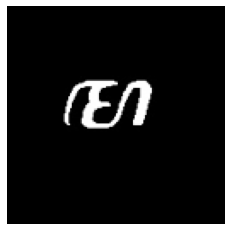

In [143]:
test0 = open_image_bw_resize('test-images/test-image-0.jpg')
test0.show()

Feed it through the model and see its output.

In [144]:
learn.predict(test0)[0]

'ma'

Luckily, the model was able to predict the character correctly. To challenge the model even more, I tried to write Javanese Script characters myself and see what the model predicts. Do note that I do not have any background in writing Javanese Scripts, so pardon my skills.

The following character is supposed to be **ca**.

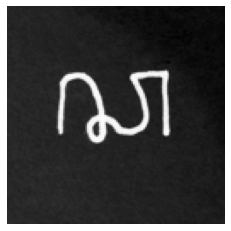

In [145]:
test1 = open_image_bw_resize('test-images/test-image-1.jpg')
test1.show()

In [146]:
learn.predict(test1)[0]

'ca'

This character is supposed to be **wa**.

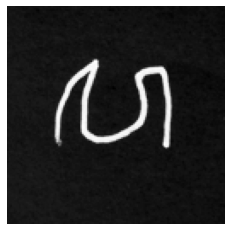

In [147]:
test2 = open_image_bw_resize('test-images/test-image-2.jpg')
test2.show()

In [148]:
learn.predict(test2)[0]

'ca'

Well that's an incorrect guess, which is reasonable firstly because of my poor handwriting skills, and secondly the model was trained on a person's particular style of handwriting - which in this case is my teacher's. There could be many other factors which caused the incorrect guess, such as overfitting by the model, small dataset and possibly more.

## Closing Remarks
There are several possible improvements which could be made, one of which is to increase the variety and the size of the dataset, since the model is only training on a single person's handwriting. It'll be better in terms of regularization to add other people's handwriting into the mix as well.

That's it for this mini project of mine. Thanks for your time and I hope you've learned something!